In [8]:
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os, os.path
import sys

import tf_utils
from deployment import model_deploy
import dataset.load_batch_cmc as load_batch_cmc

import pickle
from nets import model_cmc
from tensorflow.contrib.slim.python.slim.learning import train_step
from tensorflow.python.framework import ops

In [ ]:
slim = tf.contrib.slim

model = "CMC"
# =========================================================================== #
# Text Network flags.
# =========================================================================== #
loss_alpha = 1
negative_ratio = 3
match_threshold = 0.5
file_pattern = '*.tfrecord'
# =========================================================================== #
# General Flags.
# =========================================================================== #
train_dir = "/home/jacob/Projects/image_segmentation/data/to_record/'
num_clones = 1
shuffle_data = False
clone_on_cpu = False
worker_replicas = 1
num_ps_tasks =  0
num_readers = 2
num_preprocessing_threads = 4
log_every_n_steps = 100
save_summaries_secs = 60
save_interval_secs = 60*10
gpu_memory_fraction = 0.50
task = 0 

# =========================================================================== #
# Optimization Flags.
# =========================================================================== #
weight_decay = 0.0005
optimizer =  'adam'
adadelta_rho = 0.95
adagrad_initial_accumulator_value =  0.1
adam_beta1 = 0.9
adam_beta2 = 0.999
opt_epsilon = 1.0
tf.app.flags.DEFINE_float('ftrl_learning_rate_power', -0.5,
						  'The learning rate power.')
tf.app.flags.DEFINE_float(
	'ftrl_initial_accumulator_value', 0.1,
	'Starting value for the FTRL accumulators.')
tf.app.flags.DEFINE_float(
	'ftrl_l1', 0.0, 'The FTRL l1 regularization strength.')
tf.app.flags.DEFINE_float(
	'ftrl_l2', 0.0, 'The FTRL l2 regularization strength.')
tf.app.flags.DEFINE_float(
	'momentum', 0.9,
	'The momentum for the MomentumOptimizer and RMSPropOptimizer.')
tf.app.flags.DEFINE_float('rmsprop_momentum', 0.9, 'Momentum.')
tf.app.flags.DEFINE_float('rmsprop_decay', 0.9, 'Decay term for RMSProp.')

# =========================================================================== #
# Learning Rate Flags.
# =========================================================================== #
tf.app.flags.DEFINE_string(
	'learning_rate_decay_type',
	'fixed',
	'Specifies how the learning rate is decayed. One of "fixed", "exponential",'
	' or "polynomial"')
tf.app.flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
tf.app.flags.DEFINE_float(
	'end_learning_rate', 0.001,
	'The minimal end learning rate used by a polynomial decay learning rate.')
tf.app.flags.DEFINE_float(
	'label_smoothing', 0.0, 'The amount of label smoothing.')
tf.app.flags.DEFINE_float(
	'learning_rate_decay_factor', 0.94, 'Learning rate decay factor.')
tf.app.flags.DEFINE_float(
	'num_epochs_per_decay', 1,
	'Number of epochs after which learning rate decays.')
tf.app.flags.DEFINE_float(
	'moving_average_decay', None,
	'The decay to use for the moving average.'
	'If left as None, then moving averages are not used.')
tf.app.flags.DEFINE_boolean(
	'use_batch', False,
	'Wheather use batch_norm or not')
tf.app.flags.DEFINE_boolean(
	'use_hard_neg', True,
	'Wheather use use_hard_neg or not')
tf.app.flags.DEFINE_boolean(
	'use_whiten', True,
	'Wheather use whiten or nbot,genally you can choose whiten or batchnorm tech.')
tf.app.flags.DEFINE_float('clip_gradient_norm', 0,
                   'If greater than 0 then the gradients would be clipped by '
                   'it.')
# =========================================================================== #
# Dataset Flags.
# =========================================================================== #
tf.app.flags.DEFINE_string(
	'dataset_name', 'sythtext', 'The name of the dataset to load.')
tf.app.flags.DEFINE_integer(
	'num_classes', 2, 'Number of classes to use in the dataset.')
tf.app.flags.DEFINE_string(
	'dataset_split_name', 'train', 'The name of the train/test split.')
tf.app.flags.DEFINE_string(
	'dataset_dir', "/data/CVPR_Release/v2/dataset/shuffle/", 'The directory where the dataset files are stored.')
tf.app.flags.DEFINE_integer(
	'labels_offset', 0,
	'An offset for the labels in the dataset. This flag is primarily used to '
	'evaluate the VGG and ResNet architectures which do not use a background '
	'class for the ImageNet dataset.')
tf.app.flags.DEFINE_string(
	'model_name', 'text_box_300', 'The name of the architecture to train.')
tf.app.flags.DEFINE_string(
	'data_format', 'NHWC', 'data format.')
tf.app.flags.DEFINE_string(
	'preprocessing_name', None, 'The name of the preprocessing to use. If left '
	'as `None`, then the model_name flag is used.')
tf.app.flags.DEFINE_integer(
	'batch_size', 10, 'The number of samples in each batch.')
tf.app.flags.DEFINE_integer(
	'train_image_size', None, 'Train image size')
tf.app.flags.DEFINE_integer('max_number_of_steps', 40000,
							'The maximum number of training steps.')
tf.app.flags.DEFINE_integer('num_samples', 40000,
							'Num of training set')
# =========================================================================== #
# Fine-Tuning Flags.
# =========================================================================== #
tf.app.flags.DEFINE_string(
	'checkpoint_path', None,
	'The path to a checkpoint from which to fine-tune.')
tf.app.flags.DEFINE_string(
	'checkpoint_model_scope', None,
	'Model scope in the checkpoint. None if the same as the trained model.')
tf.app.flags.DEFINE_string(
	'checkpoint_exclude_scopes', None,
	'Comma-separated list of scopes of variables to exclude when restoring '
	'from a checkpoint.')
tf.app.flags.DEFINE_string(
	'trainable_scopes', None,
	'Comma-separated list of scopes to filter the set of variables to train.'
	'By default, None would train all the variables.')
tf.app.flags.DEFINE_boolean(
	'ignore_missing_vars', False,
	'When restoring a checkpoint would ignore missing variables.')
tf.app.flags.DEFINE_boolean(
    'fine_tune', False,
    'Weather use fine_tune')
tf.app.flags.DEFINE_integer(
    'validation_check', 1000,
    'frequency to eval'
)


In [2]:
main_dir = os.path.join(os.getcwd(),"..")
#/home/jacob/Projects/image_segmentation/
dataset_dir = "/home/jacob/Projects/image_segmentation/data/to_record/train_cmc_original2.tfrecord"
num_readers = 2
batch_size = 3
file_pattern = "*.tfrecord"
shuffle_data = False

In [4]:
batch_queue = \
load_batch_cmc.get_batch(dataset_dir,
                        num_readers,
                        batch_size,
                        None,
                        None,
                        file_pattern = file_pattern,
                        is_training = True,
                        shuffe = shuffle_data)


image (3, 240, 240, 4) (3, 240, 240, 1)


(3, 3, 240, 240, 4)


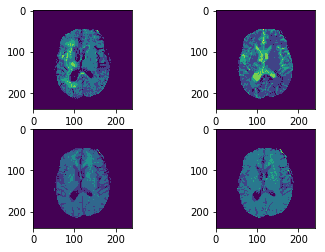

In [6]:
from matplotlib import pyplot
import numpy as np

with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    images,label = sess.run(batch_queue)
    img = images.astype(np.uint8)
    print(img.shape)
    for i in range(4):
        pyplot.subplot(2,2,i+1)
        pyplot.imshow(img[1,0,:,:,i])
    coord.request_stop()
    # Wait for threads to stop
    coord.join(threads)

In [ ]:
tf.train.get_or_create_global_step